In [26]:
import os
import glob 
import pandas as pd
import string
import collections

from tqdm import tqdm


from PIL import Image

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
from torch.utils.data import DataLoader
import torch.optim as optim

In [27]:
data = glob.glob(os.path.join('../input/captcha-version-2-images/samples', '*.png'))
path = '../input/captcha-version-2-images/samples'
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [28]:
DEVICE

device(type='cuda')

In [29]:
all_letters = string.ascii_lowercase + string.digits

mapping = {}
mapping_inv = {}
i = 1
for x in all_letters:
    mapping[x] = i
    mapping_inv[i] = x
    i += 1

In [30]:
num_class = len(mapping)

In [31]:
images = []
labels = []
datas = collections.defaultdict(list)
for d in data:
    x = d.split('/')[-1]
    datas['image'].append(x)
    datas['label'].append([mapping[i] for i in x.split('.')[0]])
df = pd.DataFrame(datas)
df.head()

,image,label
0,6n6gg.png,"[33, 14, 33, 7, 7]"
1,fncnb.png,"[6, 14, 3, 14, 2]"
2,nbwnn.png,"[14, 2, 23, 14, 14]"
3,ebcbx.png,"[5, 2, 3, 2, 24]"
4,nxn4f.png,"[14, 24, 14, 31, 6]"


In [32]:
df_train, df_test = train_test_split(df, test_size=0.2, shuffle=True)

In [33]:
class CaptchaDataset:
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        data = self.df.iloc[idx]
        image = Image.open(os.path.join(path, data['image'])).convert('L')
        label = torch.tensor(data['label'], dtype=torch.int32)
        
        if self.transform is not None:
            image = self.transform(image)
        
        return image, label
        
        
transform = T.Compose([
    T.ToTensor()
])

train_data = CaptchaDataset(df_train, transform)
test_data = CaptchaDataset(df_test, transform)

train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
test_loader = DataLoader(test_data, batch_size=8)

In [34]:
class Bidirectional(nn.Module):
    def __init__(self, inp, hidden, out, lstm=True):
        super(Bidirectional, self).__init__()
        if lstm:
            self.rnn = nn.LSTM(inp, hidden, bidirectional=True)
        else:
            self.rnn = nn.GRU(inp, hidden, bidirectional=True)
        self.embedding = nn.Linear(hidden*2, out)
    def forward(self, X):
        recurrent, _ = self.rnn(X)
        out = self.embedding(recurrent)     
        return out
    
    
class CRNN(nn.Module):
    def __init__(self, in_channels, output):
        super(CRNN, self).__init__()

        self.cnn = nn.Sequential(
                nn.Conv2d(in_channels, 256, 9, stride=1, padding=1),
                nn.ReLU(),
                nn.BatchNorm2d(256),
                nn.MaxPool2d(3, 3),
                nn.Conv2d(256, 256, (4, 3), stride=1, padding=1),
                nn.ReLU(),
                nn.BatchNorm2d(256))
        
        self.linear = nn.Linear(3328, 256)
        self.bn1 = nn.BatchNorm1d(256)
        self.rnn = Bidirectional(256, 1024, output+1)

    def forward(self, X, y=None, criterion = None):
        out = self.cnn(X)
        N, C, w, h = out.size()
        out = out.view(N, -1, h)
        out = out.permute(0, 2, 1)
        out = self.linear(out)

        out = out.permute(1, 0, 2)
        out = self.rnn(out)
            
        if y is not None:
            T = out.size(0)
            N = out.size(1)
        
            input_lengths = torch.full(size=(N,), fill_value=T, dtype=torch.int32)
            target_lengths = torch.full(size=(N,), fill_value=5, dtype=torch.int32)
        
            loss = criterion(out, y, input_lengths, target_lengths)
            
            return out, loss
        
        return out, None
    
    def _ConvLayer(self, inp, out, kernel, stride, padding, bn=False):
        if bn:
            conv = [
                nn.Conv2d(inp, out, kernel, stride=stride, padding=padding),
                nn.ReLU(),
                nn.BatchNorm2d(out)
            ]
        else:
            conv = [
                nn.Conv2d(inp, out, kernel, stride=stride, padding=padding),
                nn.ReLU()
            ]
        return nn.Sequential(*conv)

In [35]:
class Engine:
    def __init__(self, model, optimizer, criterion, epochs=50, early_stop=False, device='cpu'):
        self.model = model
        self.optimizer = optimizer
        self.criterion = criterion
        self.epochs = epochs
        self.early_stop = early_stop
        self.device = device
        
    def fit(self, dataloader):
        hist_loss = []
        for epoch in range(self.epochs):
            self.model.train()
            tk = tqdm(dataloader, total=len(dataloader))
            for data, target in tk:
                data = data.to(device=self.device)
                target = target.to(device=self.device)

                self.optimizer.zero_grad()

                out, loss = self.model(data, target, criterion=self.criterion)

                loss.backward()

                self.optimizer.step()


                tk.set_postfix({'Epoch':epoch+1, 'Loss' : loss.item()})
                
    def evaluate(self, dataloader):
        self.model.eval()
        loss = 0
        hist_loss = []
        outs = collections.defaultdict(list)
        tk = tqdm(dataloader, total=len(dataloader))
        with torch.no_grad():
            for data, target in tk:
                data = data.to(device=self.device)
                target = target.to(device=self.device)

                out, loss = self.model(data, target, criterion=self.criterion)
                
                outs['pred'].append(out)
                outs['target'].append(target)
                

                hist_loss.append(loss)

                tk.set_postfix({'Loss':loss.item()})
                
        return outs, hist_loss
    
    def predict(self, image):
        image = Image.open(image).convert('L')
        image_tensor = T.ToTensor()(image)
        image_tensor = image_tensor.unsqueeze(0)        
        out, _ = self.model(image_tensor.to(device=self.device))
        out = out.permute(1, 0, 2)
        out = out.log_softmax(2)
        out = out.argmax(2)
        out = out.cpu().detach().numpy()
        
        return out
        
            
            
            
model = CRNN(in_channels=1, output=num_class).to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.CTCLoss()

engine = Engine(model, optimizer, criterion, device=DEVICE)
engine.fit(train_loader)
outs, loss = engine.evaluate(test_loader)

100%|██████████| 26/26 [00:02<00:00, 11.83it/s, Loss=0.242]


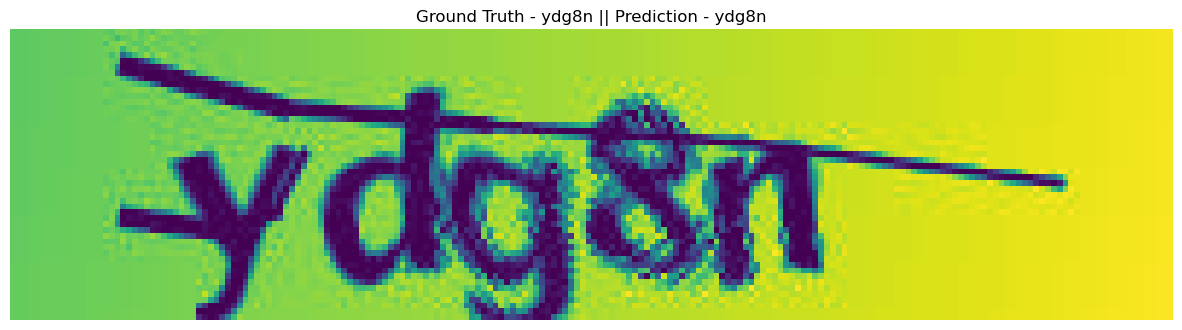

In [42]:
import matplotlib.pyplot as plt
import numpy as np

ids = np.random.randint(len(data))

image = data[ids]
out = engine.predict(image)[0]

def show_prediction(out, image):
    gt = image.split('/')[-1].split('.')[0]
    imagePIL = Image.open(image).convert('L')

    pred = ''
    then = 0
    for x in out:
        if then != x:
            if x > 0 :
                pred += mapping_inv[x]
        then = x

    plt.figure(figsize=(15, 12))
    img_array = np.asarray(imagePIL)
    plt.title(f'Ground Truth - {gt} || Prediction - {pred}')
    plt.axis('off')
    plt.imshow(img_array)
    
show_prediction(out, image)

In [38]:
saving = {'state_dict':engine.model.state_dict(),
          'optimizer':engine.optimizer.state_dict(),
         'mapping':mapping,
         'mapping_inv':mapping_inv}
torch.save(saving, './model.pth')